# Inferring transition probabilities from time-resolved single-cell data

Here, we show how to infer cell-cell transition probabilities, using the RealTimeKernel. The required data can be downloaded [here](https://figshare.com/ndownloader/files/53395853) from FigShare. The data is expected to be in `data/larry/processed/`, _i.e._,

```bash
mkdir -p ../../data/larry/processed/
wget https://figshare.com/ndownloader/files/53395853 -O ../../data/larry/processed/adata.h5ad
```

## Library imports

In [1]:
import matplotlib.pyplot as plt
import mplscience

import anndata as ad
import cellrank as cr
import scanpy as sc
import scvelo as scv
from moscot.problems.time import TemporalProblem

from crp import DATA_DIR, FIG_DIR

## General settings

In [2]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

## Constants

In [4]:
DATASET = "larry"

In [5]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

## Function definitions

## Data loading

In [6]:
adata = ad.io.read_zarr(DATA_DIR / DATASET / "processed" / "adata.zarr")
adata

AnnData object with n_obs × n_vars = 130887 × 25289
    obs: 'day', 'cell_type'
    obsm: 'latent_rep'

In [7]:
sc.pp.subsample(adata, fraction=0.25, random_state=0)
adata

AnnData object with n_obs × n_vars = 32721 × 25289
    obs: 'day', 'cell_type'
    obsm: 'latent_rep'

## Data preprocessing

In [8]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, subset=True)
adata

extracting highly variable genes
    finished (0:00:00)


AnnData object with n_obs × n_vars = 32721 × 1500
    obs: 'day', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'latent_rep'

In [9]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:11)


Renamed 'latent_rep' to convention 'X_latent_rep' (adata.obsm).


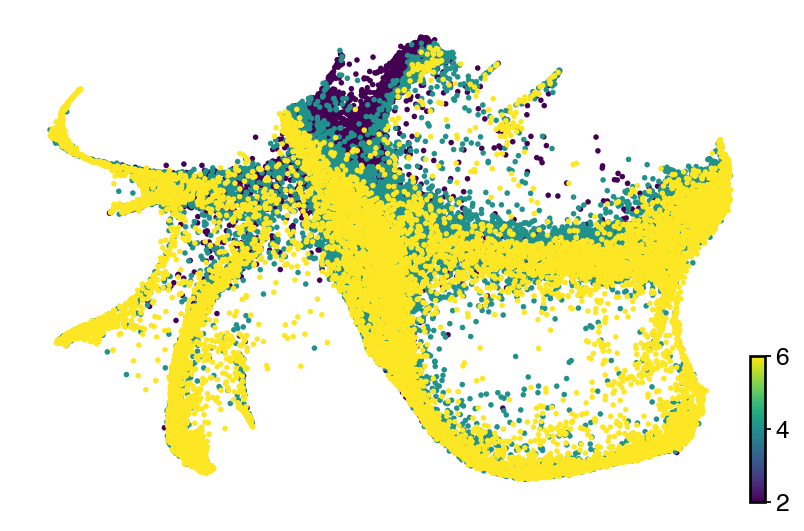

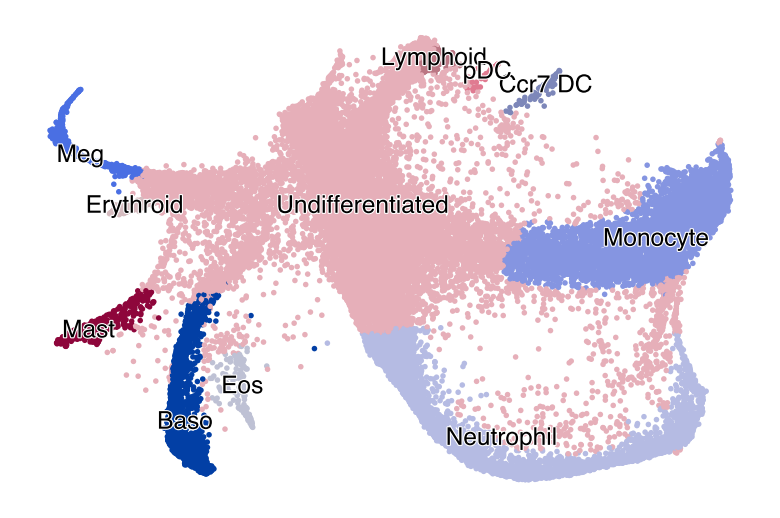

In [10]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="latent_rep", color="day", color_map="viridis", size=25, title="", ax=ax)
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="latent_rep", color="cell_type", size=25, title="", ax=ax)
    plt.show()

## CellRank pipeline

In [11]:
adata.obs["day"] = adata.obs["day"].astype("category")

In [12]:
tp = TemporalProblem(adata)
tp = tp.prepare(time_key="day")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:00)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:00)


In [13]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `2` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(7004, 12136)].                                 
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(12136, 13581)].                                


In [14]:
rtk = cr.kernels.RealTimeKernel.from_moscot(tp)
rtk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

  0%|          | 0/2 [00:00<?, ?time pair/s]

Using automatic `threshold=1.0144462310110458e-12`
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


RealTimeKernel[n=32721, threshold='auto', self_transitions='all']